<a href="https://colab.research.google.com/github/jnunez03/CppFolder/blob/master/CkStartsAlert_Prod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Cooking Starts</h1>   


In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
from scipy import stats
from scipy.stats import norm
from fbprophet import Prophet
import logging

logger = logging.getLogger('pandas_gbq')
logger.propagate = False 
logging.getLogger().disabled = True

#  Use ET2 From September Forward  -->  09/01 To [current date]
q = """
SELECT  
  date(finance_paid_start_ts)  as start_date,
  format_datetime('%A',cast(date(finance_paid_start_ts) as datetime)) as dayName,
  count(dim_subscriber_id) as starts
FROM `nyt-dssor-prd.dssor_chartio.subscriber_summary_chartio`  
where orig_bundle_compatibility_group = 'CK'
and finance_paid_start_ts > '2019-01-01'
group by 1,2
order by 1 asc 
"""

# importing the data
df = pd.read_gbq(q,
    project_id = 'nyt-bigquery-beta-workspace',
    dialect='standard')


# Descriptive statistics, data type, data preview 
print(df.describe(), ' \n \n', '*Data Types Below* \n \n', df.dtypes ,' \n \n', df.head(n=6))

INFO:google.auth.compute_engine._metadata:Compute Engine Metadata server unavailable.


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=2mCr4JDtoBQ1nwb6hSh8YpZrGHgzov&prompt=consent&access_type=offline
Enter the authorization code: 4/tAGc8tPD0HA7ULcuFHll9kOywTa-Pewbxcft9xWf7zouIM1GK3L066M
            starts
count   317.000000
mean    677.476341
std     260.577760
min     213.000000
25%     491.000000
50%     611.000000
75%     781.000000
max    1687.000000  
 
 *Data Types Below* 
 
 start_date    datetime64[ns]
dayName               object
starts                 int64
dtype: object  
 
   start_date    dayName  starts
0 2019-01-01    Tuesday     901
1 2019-01-02  Wednesday     941
2 2019-01-03   Thursday     764
3 2019-01-04     Friday     762
4 2019-01-05   Saturday    1409
5 2019-01-06     Sunday    1359


In [2]:
df.tail(n=5)    # day before is still low, since DS-SOR run time should finish by 11 - 11:30 AM 

,start_date,dayName,starts
312,2019-11-09,Saturday,1537
313,2019-11-10,Sunday,1687
314,2019-11-11,Monday,1113
315,2019-11-12,Tuesday,1010
316,2019-11-13,Wednesday,213


In [3]:
#df.head()
dfnew = df[df['start_date'] < '2019-11-13']   # Thresholds stopped at November 12th! 
dfnew.tail(n=10)

,start_date,dayName,starts
306,2019-11-03,Sunday,1435
307,2019-11-04,Monday,1130
308,2019-11-05,Tuesday,762
309,2019-11-06,Wednesday,767
310,2019-11-07,Thursday,669
311,2019-11-08,Friday,922
312,2019-11-09,Saturday,1537
313,2019-11-10,Sunday,1687
314,2019-11-11,Monday,1113
315,2019-11-12,Tuesday,1010


In [0]:
dfnew['month'] = dfnew['start_date'].dt.month
dfnew.tail(n=10)

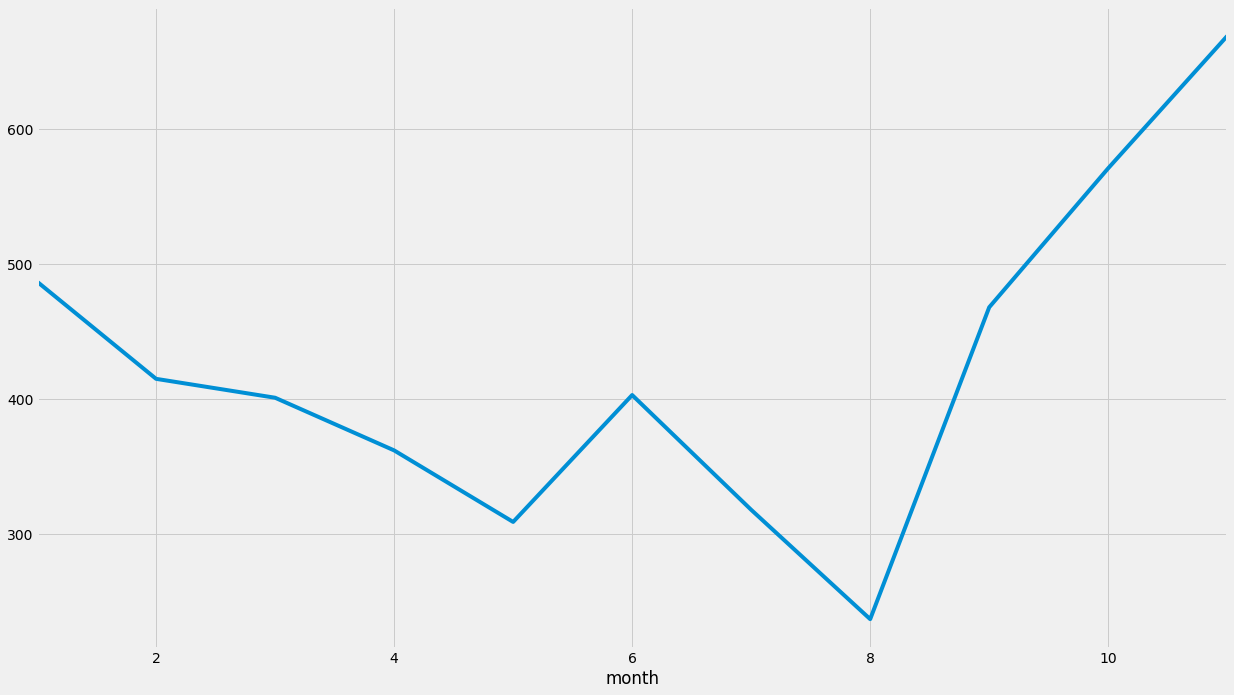

In [7]:
dfnew.groupby(['month']).min().starts.plot()
#dfnew.groupby(['start_date', 'month'])['starts'].min()

Text(737026, 1690, 'Cooking Starts')

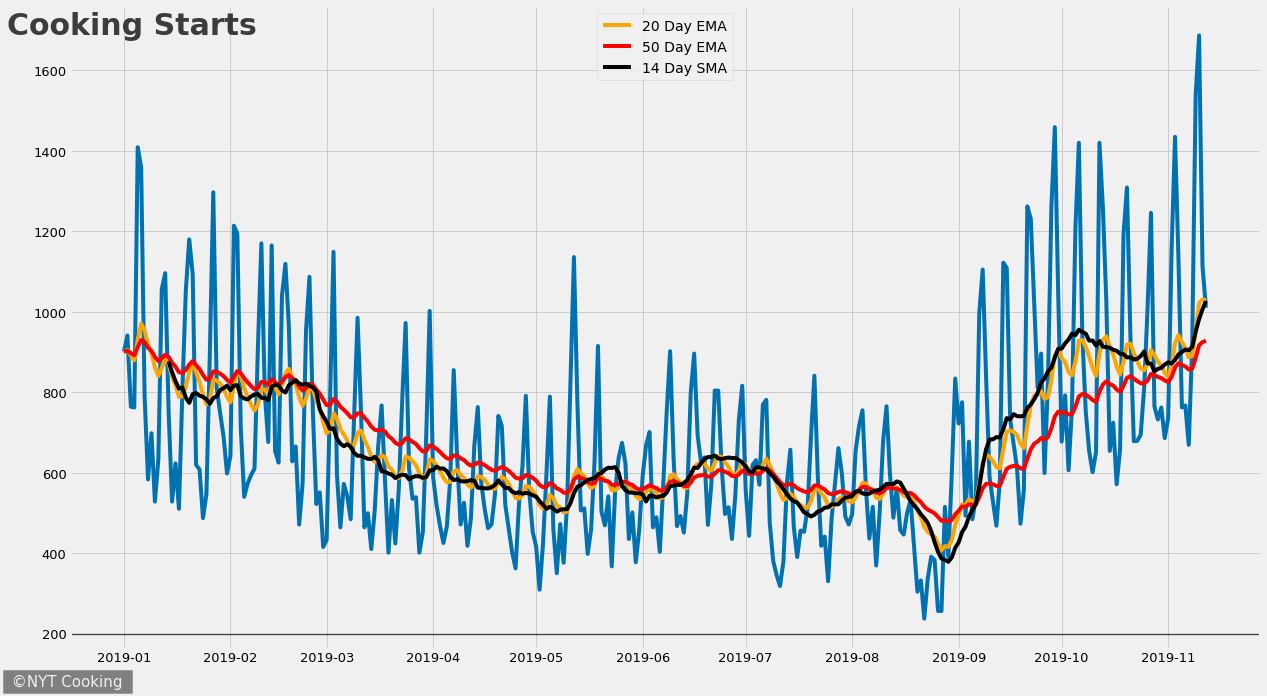

In [5]:
%matplotlib inline
style.use('fivethirtyeight')
rcParams['figure.figsize'] = 19,11

# Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

# Rolling Averages
rolling_mean = dfnew.starts.rolling(window=14).mean()
exp1 = dfnew.starts.ewm(span=20, adjust=False).mean()
exp2 = dfnew.starts.ewm(span=50, adjust=False).mean()

ax = sb.lineplot(x="start_date", y="starts", data=dfnew, color = colors[5])
plt.plot(dfnew['start_date'], exp1, label='20 Day EMA', color='orange')
plt.plot(dfnew['start_date'], exp2, label='50 Day EMA', color='red')
plt.plot(dfnew['start_date'], rolling_mean, label='14 Day SMA', color=colors[0])
#plt.plot(df['start_date'], df.groupby(['month']).min().starts, label='14 Day SMA', color=colors[4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax.axhline(y = 200, color = 'black', linewidth = 1.3, alpha = .7)
plt.legend(loc='upper center')
#ax.set_xlim(left = '2019', right = '2019')


# Remove the label of the x-axis
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

# The signature bar
#ax.get_xlim()
ax.text(x = ax.get_xlim()[0].astype(int) - 18,y = 70, s = ' ©NYT Cooking ',fontsize = 15, color = '#f0f0f0', backgroundcolor = 'grey')
#print(ax.get_xlim()[0].astype(int))
#ax.get_xlim()[0]


# Adding a title and a subtitle
ax.text(x = ax.get_xlim()[0].astype(int) - 18, y = 1690, s = "Cooking Starts",
               fontsize = 30, weight = 'bold', alpha = .75)

When short-term crosses above long-term we get a buy signal. When short-term passes below the longer-term we get a sell signal.


In [0]:
from scipy.stats import gaussian_kde

kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=25)

plt.hist(dfnew.starts, **kwargs)

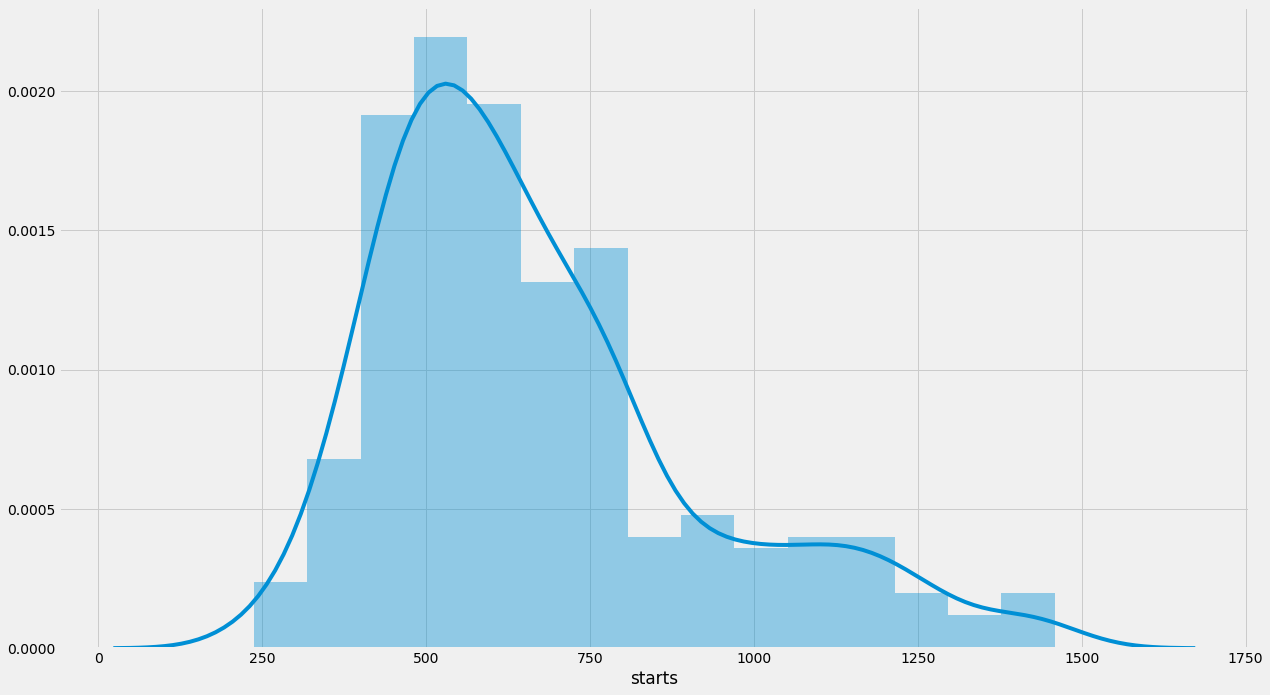

In [13]:
sb.distplot(dfnew.starts)

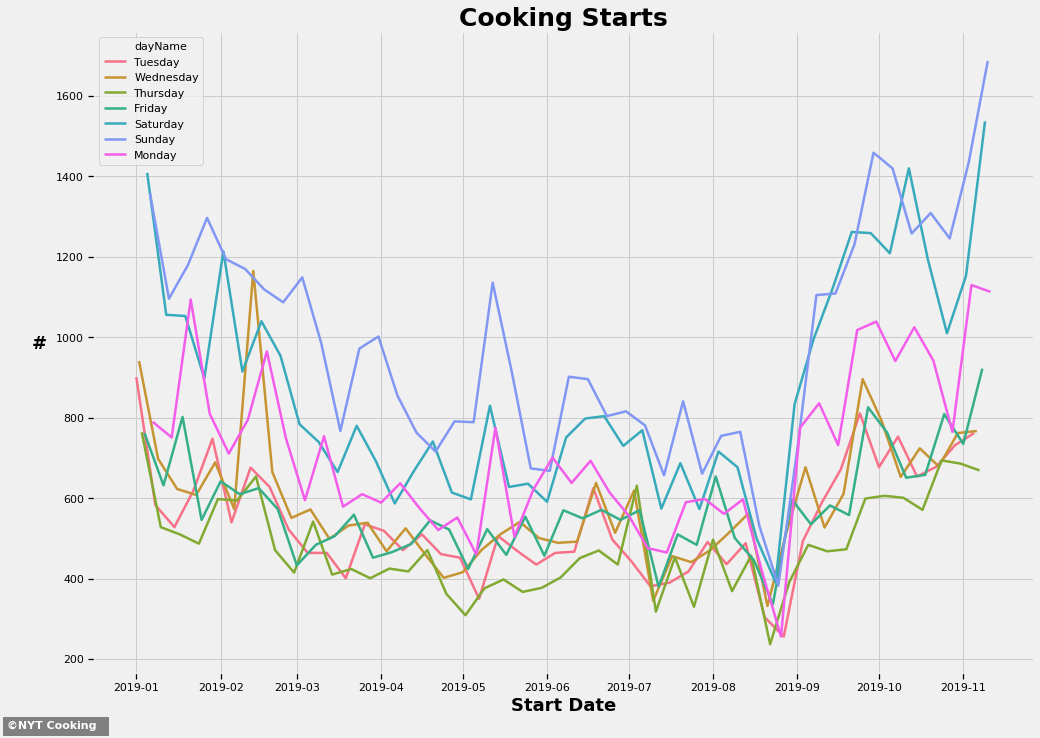

In [11]:
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')   #bmh, ggplot,seaborn-notebook,seaborn-deep,dark_background
rcParams['figure.figsize'] = 15,11

sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})
sb.lineplot(x="start_date", y="starts", hue="dayName", data=dfnew)   # Percent Hit WALL 
#sb.lineplot(x="day", y="paywall", hue="dayName", data=df)   # Number Hit Wall 
plt.title('Cooking Starts',fontsize=25,weight='bold')
plt.ylabel('#    ', fontsize=18, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=18, weight='bold')
#plt.text(x=1, y=1000, s='NYT Cooking', fontsize=9, color='#f0f0f0',backgroundcolor='grey')
plt.figtext(0, 0,'©NYT Cooking  ', fontsize=11, color='white',backgroundcolor='grey',weight= 'bold') #rotation=0, #color='black')
plt.show() 

In [0]:
dfMon = dfnew[dfnew['dayName'] == 'Monday']
dfMon = dfMon[dfMon['start_date'] >= '2019-09-01']

dfTue = dfnew[dfnew['dayName'] == 'Tuesday']
dfTue = dfTue[dfTue['start_date'] >= '2019-09-01']

dfWed = dfnew[dfnew['dayName'] == 'Wednesday']
dfWed = dfWed[dfWed['start_date'] >= '2019-09-01']

dfThurs = dfnew[dfnew['dayName'] == 'Thursday']
dfThurs = dfThurs[dfThurs['start_date'] >= '2019-09-01']

dfFri =  dfnew[dfnew['dayName'] == 'Friday']
dfFri = dfFri[dfFri['start_date'] >= '2019-09-01']

dfSat = dfnew[dfnew['dayName'] == 'Saturday']
dfSat= dfSat[dfSat['start_date'] >= '2019-09-01']

dfSun = dfnew[dfnew['dayName'] == 'Sunday'] 
dfSun = dfSun[dfSun['start_date'] >= '2019-09-01'] 

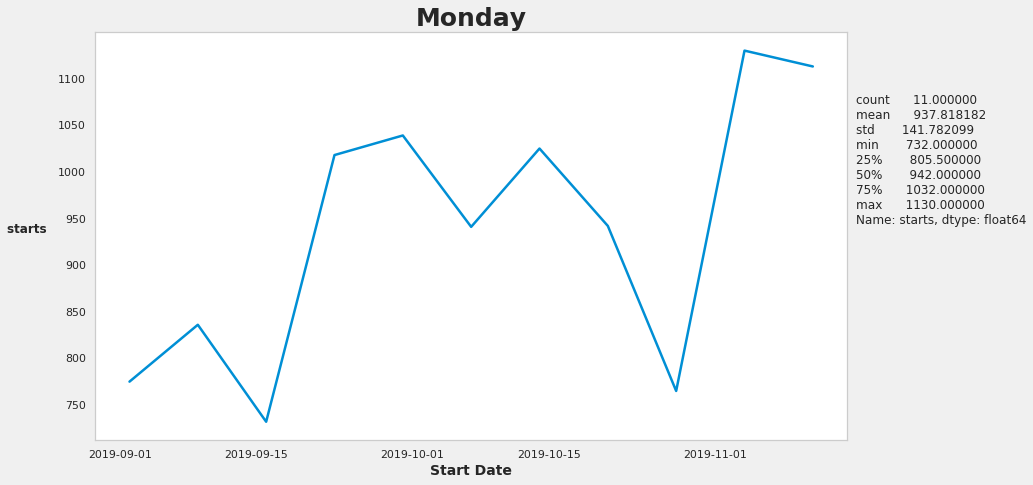

In [32]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfMon
mon = dfMon["starts"].describe()
mon1 = str(mon)

#dfMon
sb.lineplot(x="start_date", y="starts",markers=True, dashes=False, data=dfMon)
plt.title('Monday',fontsize=25,weight='bold')
plt.ylabel('starts             ', fontsize=12, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,mon1)
plt.show()

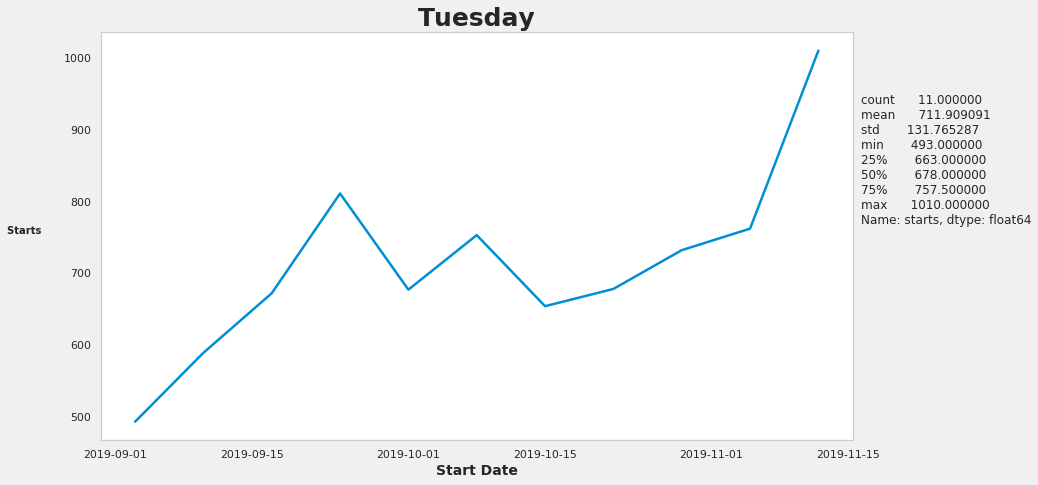

In [8]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfTue
Tue = dfTue["starts"].describe()
Tue1= str(Tue)

#dfTue
sb.lineplot(x="start_date", y="starts", data=dfTue)
plt.title('Tuesday',fontsize=25,weight='bold')
plt.ylabel('Starts                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,Tue1)
plt.show()

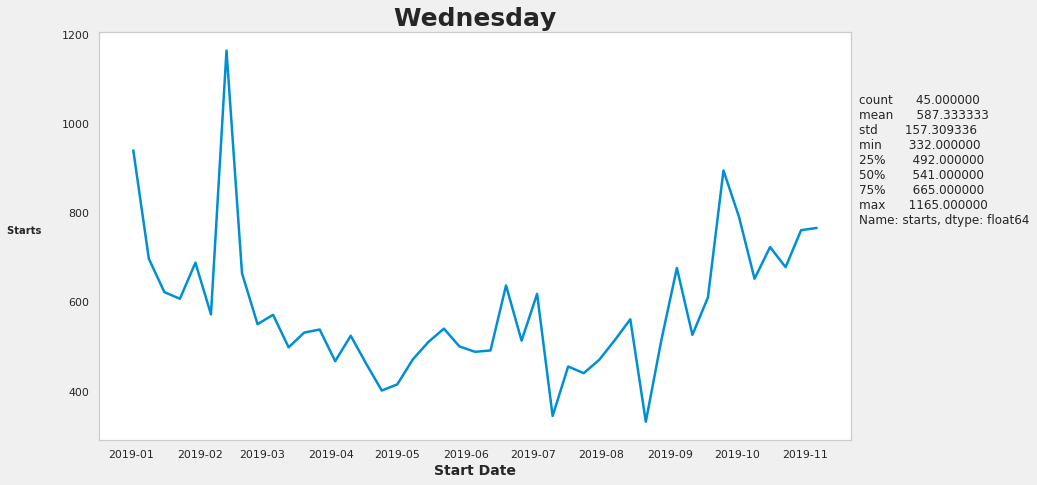

In [16]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfWed
wed = dfWed["starts"].describe()
wed1 = str(wed)

#dfWed
sb.lineplot(x="start_date", y="starts", data=dfWed)
plt.title('Wednesday',fontsize=25,weight='bold')
plt.ylabel('Starts                   ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,wed1)
plt.show()

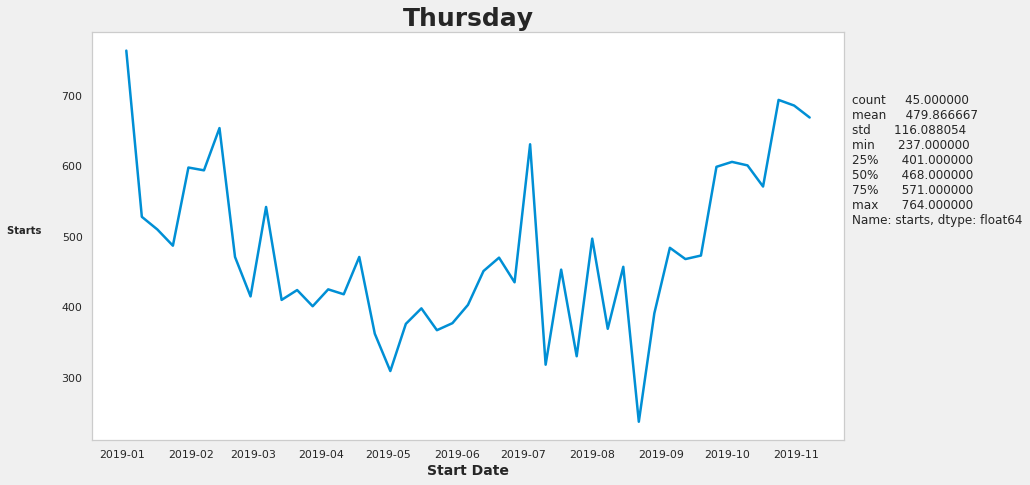

In [17]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfThurs
thurs = dfThurs["starts"].describe()
thurs1 = str(thurs)

# dfThurs
sb.lineplot(x="start_date", y="starts", data=dfThurs)
plt.title('Thursday',fontsize=25,weight='bold')
plt.ylabel('Starts                   ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,thurs1)
plt.show()

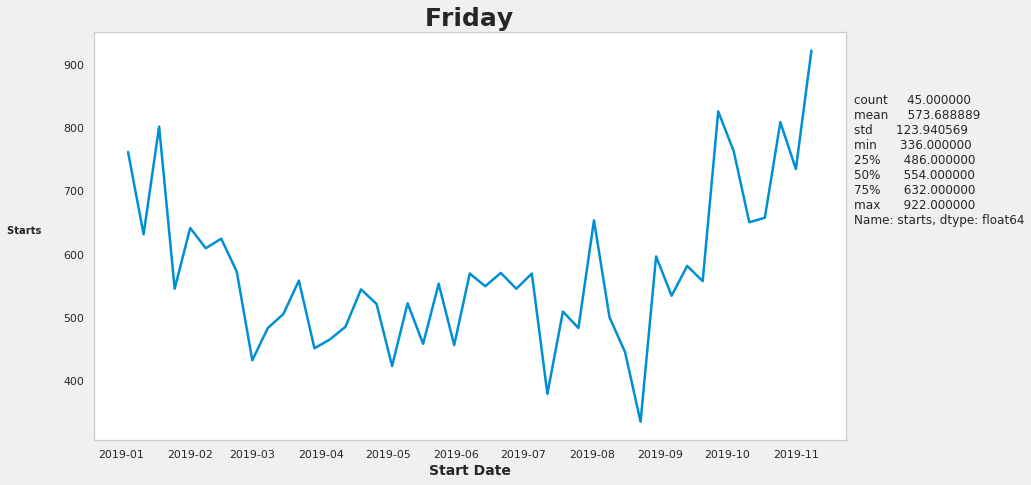

In [18]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfFri
fri = dfFri["starts"].describe()
fri1 = str(fri)

# dfFri
sb.lineplot(x="start_date", y="starts", data=dfFri)
plt.title('Friday',fontsize=25,weight='bold')
plt.ylabel('Starts                    ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,fri1)
plt.show()

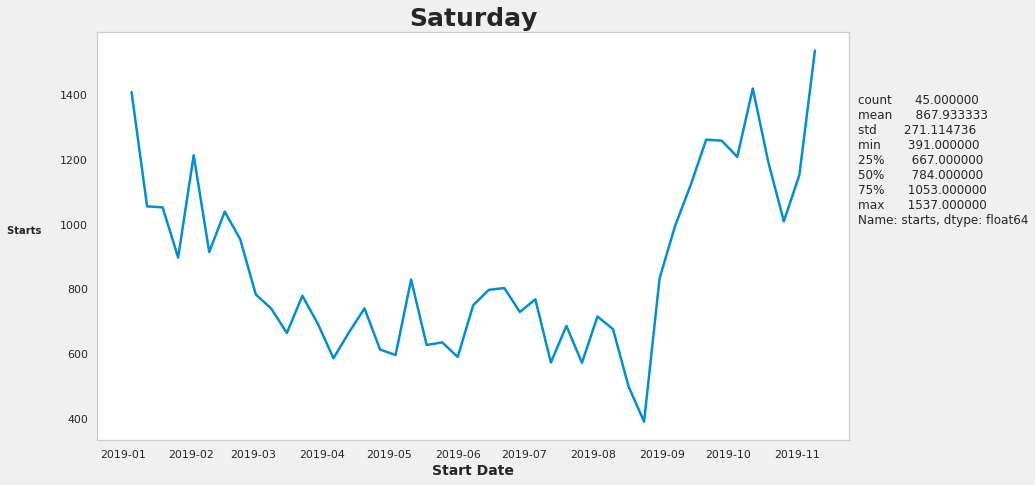

In [19]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSat
sat = dfSat["starts"].describe()
sat1 = str(sat)

# dfSat
sb.lineplot(x="start_date", y="starts", data=dfSat)
plt.title('Saturday',fontsize=25,weight='bold')
plt.ylabel('Starts                  ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,sat1)
plt.show()

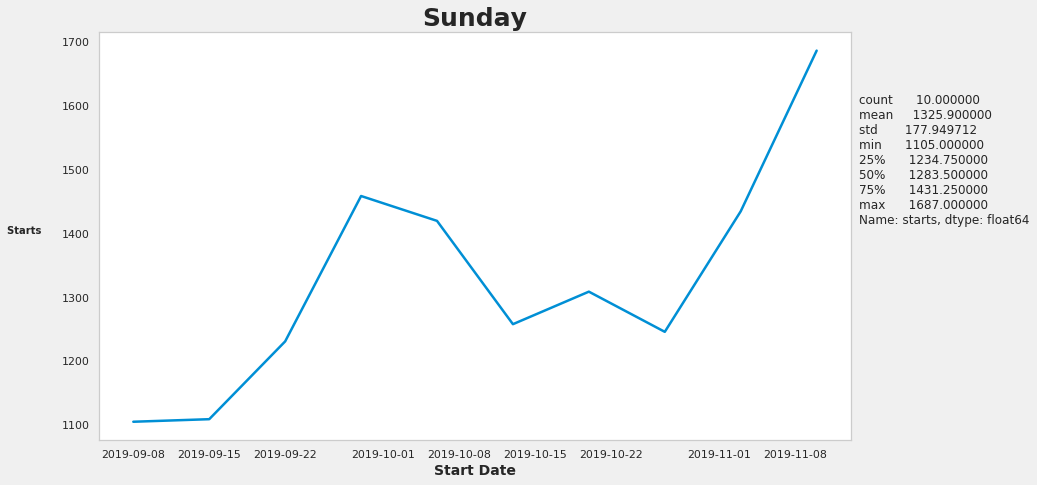

In [29]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSun
sun = dfSun["starts"].describe()
sun1 = str(sun)

# dfSun
sb.lineplot(x="start_date", y="starts", data=dfSun)
plt.title('Sunday',fontsize=25,weight='bold')
plt.ylabel('Starts                   ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,sun1)
plt.show()

In [0]:
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12,7
sb.despine()
#sb.set(font_scale = .8)
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set_context("notebook",font_scale=1.001,rc={"lines.linewidth":2.5})

# dfSun
sun = dfSun["starts"].describe()
sun1 = str(sun)

# dfSun
sb.lineplot(x="start_date", y="starts", data=dfSun)
plt.title('Sunday',fontsize=25,weight='bold')
plt.ylabel('Starts                   ', fontsize=10, rotation=0, weight='bold')
plt.xlabel('Start Date',fontsize=14, weight='bold')
plt.figtext(.96, .5,sun1)
plt.show()

In [18]:
dfTue.head(n=11)

,start_date,dayName,starts,month
245,2019-09-03,Tuesday,493,9
252,2019-09-10,Tuesday,589,9
259,2019-09-17,Tuesday,672,9
266,2019-09-24,Tuesday,811,9
273,2019-10-01,Tuesday,677,10
280,2019-10-08,Tuesday,753,10
287,2019-10-15,Tuesday,654,10
294,2019-10-22,Tuesday,678,10
301,2019-10-29,Tuesday,732,10
308,2019-11-05,Tuesday,762,11


# **Thresholds For Starts by Day Below** 

In [10]:
# Monday
  MondayAverage = np.mean(dfMon["starts"])
  MondaySD= np.std(dfMon["starts"])
  Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))
  minMon = dfMon["starts"].min() 

print('Threshold Monday: ', Mondaylow, '-', MondayHigh, '. Min is: ', minMon)

Threshold Monday:  667.4503271100008 - 1208.1860365263628 . Min is:  732


In [21]:
# Tuesday
  TuesdayAverage = np.mean(dfTue["starts"])
  TuesdaySD= np.std(dfTue["starts"])
  Tuesdaylow, TuesdayHigh = ( TuesdayAverage - (2*(TuesdaySD)) ) , ( TuesdayAverage + (2*(TuesdaySD)))
  minTue = dfTue["starts"].min() 

print('Threshold Tuesday: ', Tuesdaylow, '-', TuesdayHigh, '. Min is: ', minTue)

Threshold Tuesday:  460.64254710936837 - 963.1756347088134 . Min is:  493


In [12]:
# Wednesday
  WednesdayAverage = np.mean(dfWed["starts"])
  WednesdaySD = np.std(dfWed["starts"])
  Wednesdaylow, WednesdayHigh = ( WednesdayAverage - (2*(WednesdaySD)) ) , ( WednesdayAverage + (2*(WednesdaySD)))
  minWed = dfWed["starts"].min() 

print('Threshold Wednesday: ', Wednesdaylow, '-', WednesdayHigh, '. Min is: ', minWed)

Threshold Wednesday:  512.796326565036 - 904.8036734349639 . Min is:  527


In [13]:
# Thursday
  ThursdayAverage = np.mean(dfThurs["starts"])
  ThursdaySD= np.std(dfThurs["starts"])
  Thursdaylow, ThursdayHigh = ( ThursdayAverage - (2*(ThursdaySD)) ) , ( ThursdayAverage + (2*(ThursdaySD)))
  minThurs = dfThurs["starts"].min() 

print('Threshold Thursday: ', Thursdaylow, '-', ThursdayHigh, '. Min is: ', minThurs)

Threshold Thursday:  421.8077466626172 - 748.3922533373828 . Min is:  468


In [14]:
# Friday
  FridayAverage = np.mean(dfFri["starts"])
  FridaySD= np.std(dfFri["starts"])
  Fridaylow, FridayHigh = ( FridayAverage - (2*(FridaySD)) ) , ( FridayAverage + (2*(FridaySD)))
  minFri = dfFri["starts"].min() 

print('Threshold Friday: ', Fridaylow, '-', FridayHigh, '. Min is: ', minFri)

Threshold Friday:  460.95070487856935 - 946.8492951214306 . Min is:  535


In [15]:
# Saturday
  SaturdayAverage = np.mean(dfSat["starts"])
  SaturdaySD= np.std(dfSat["starts"])
  Saturdaylow, SaturdayHigh = ( SaturdayAverage - (2*(SaturdaySD)) ) , ( SaturdayAverage + (2*(SaturdaySD)))
  minSat = dfSat["starts"].min() 

print('Threshold Saturday: ', Saturdaylow, '-', SaturdayHigh, '. Min is: ', minSat)

Threshold Saturday:  898.0805666315342 - 1534.1194333684657 . Min is:  996


In [16]:
# Sunday
  SundayAverage = np.mean(dfSun["starts"])
  SundaySD= np.std(dfSun["starts"])
  Sundaylow, SundayHigh = ( SundayAverage - (2*(SundaySD)) ) , ( SundayAverage + (2*(SundaySD)))
  minSun = dfSun["starts"].min() 

print('Threshold Sunday: ', Sundaylow, '-', SundayHigh, '. Min is: ', minSun)

Threshold Sunday:  797.5077518153976 - 1744.4922481846024 . Min is:  722


Thresholds Finished.

In [0]:
def ThresholdForAlerts(df):
  # Take each df segment and print the mean % hit paywall and interval
  
  # Monday
  MondayAverage = np.mean(df[df['dayName'] == 'Monday']["starts"])
  MondaySD= np.std(df[df['dayName'] == 'Monday']["starts"])
  Mondaylow, MondayHigh = ( MondayAverage - (2*(MondaySD)) ) , ( MondayAverage + (2*(MondaySD)))
  minMon = df[df['dayName'] == 'Monday']["starts"].min()

  
  # Tuesday
  TuesdayAverage = np.mean(df[df['dayName'] == 'Tuesday']["starts"])
  TuesdaySD = np.std(df[df['dayName'] == 'Tuesday']["starts"])
  Tuesdaylow, TuesdayHigh = ( TuesdayAverage - (2*(TuesdaySD)) ) , ( TuesdayAverage + (2*(TuesdaySD)))
  minTue = df[df['dayName'] == 'Tuesday']["starts"].min()
  
  # Wednesday
  WedAverage = np.mean(df[df['dayName'] == 'Wednesday']["starts"])
  WedSD = np.std(df[df['dayName'] == 'Wednesday']["starts"]) 
  Wedlow, WedHigh = ( WedAverage - (2*(WedSD)) ) , ( WedAverage + (2*(WedSD)))
  minWed = df[df['dayName'] == 'Wednesday']["starts"].min()
  
  # Thursday
  ThursAverage = np.mean(df[df['dayName'] == 'Thursday']["starts"])
  ThursSD = np.std(df[df['dayName'] == 'Thursday']["starts"])
  Thurslow, ThursHigh = ( ThursAverage - (2*(ThursSD)) ) , ( ThursAverage + (2*(ThursSD)))
  minThurs = df[df['dayName'] == 'Thursday']["starts"].min()
  
  # Friday
  FriAverage = np.mean(df[df['dayName'] == 'Friday']["starts"])
  FriSD = np.std(df[df['dayName'] == 'Friday']["starts"])
  Frilow, FriHigh = ( FriAverage - (2*(FriSD)) ) , ( FriAverage + (2*(FriSD)))
  minFri = df[df['dayName'] == 'Friday']["starts"].min()
  
  # Saturday
  SatAverage = np.mean(df[df['dayName'] == 'Saturday']["starts"])
  SatSD = np.std(df[df['dayName'] == 'Saturday']["starts"])
  Satlow, SatHigh = ( SatAverage - (2*(SatSD)) ) , ( SatAverage + (2*(SatSD)))
  minSat = df[df['dayName'] == 'Saturday']["starts"].min()
  
  # Sunday
  SunAverage = np.mean(df[df['dayName'] == 'Sunday']["starts"])
  SunSD = np.std(df[df['dayName'] == 'Sunday']["starts"])
  Sunlow, SunHigh = ( SunAverage - (2*(SunSD)) ) , ( SunAverage + (2*(SunSD)))
  minSun = df[df['dayName'] == 'Sunday']["starts"].min() 
  
   
  return(print(
            '\n', 
          '----------------------------------------------',
           '\n',
         'Monday Avg:', round(MondayAverage,3),
         '\n',
         'Monday Thresholds:', round(Mondaylow,3), '-', round(MondayHigh,3),
         '\n',
         'Monday min:', round(minMon,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Tuesday Avg:', round(TuesdayAverage,3),
         '\n',
         'Tuesday Thresholds:', round(Tuesdaylow,3), '-', round(TuesdayHigh,3),
         '\n',
         'Tuesday min:', round(minTue,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Wednesday Avg:', round(WedAverage,3),
         '\n',
         'Wednesday Thresholds:', round(Wedlow,3), '-', round(WedHigh,3),
         '\n',
         'Wednesday min:', round(minWed,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Thursday Avg:', round(ThursAverage,3),
         '\n',
         'Thursday Thresholds:', round(Thurslow,3), '-', round(ThursHigh,3),
         '\n',
         'Thursday min:', round(minThurs,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Friday Avg:', round(FriAverage,3),
         '\n',
         'Friday Thresholds:', round(Frilow,3), '-', round(FriHigh,3),
         '\n',
         'Friday min:', round(minFri,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Saturday Avg:', round(SatAverage,3),
         '\n',
         'Saturday Thresholds:', round(Satlow,3), '-', round(SatHigh,3),
         '\n',
         'Saturday min:', round(minSat,3),
         '\n',
         '----------------------------------------------',
         '\n',
               
         'Sunday Avg:', round(SunAverage,3),
         '\n',
         'Sunday Thresholds:', round(Sunlow,3), '-', round(SunHigh,3),
         '\n',
         'Sunday min:', round(minSun,3),
         '\n',
       '----------------------------------------------',
       '\n'
        ))  

In [0]:
# starts Threshold
ThresholdForAlerts(dfnew)